In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


https://mycourses.aalto.fi/pluginfile.php/1140016/mod_resource/content/1/datascience_lecture_Final_PRoject.pdf

# 1. Importing data

In [25]:
df_train_x = pd.read_csv("data/football_train_x.csv")
df_train_y = pd.read_csv("data/football_train_y.csv")
df_test_x = pd.read_csv("data/football_test_x.csv")
df_test_y = pd.read_csv("data/football_test_y.csv")
num_rows: int = df_train_x.shape[0]
num_cols: int = df_train_x.shape[1]
num_cols

15

In [26]:
df_train_x.shape

(798, 15)

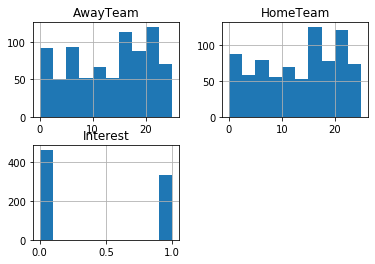

In [29]:
df_train_x.hist(column=["HomeTeam","AwayTeam","Interest"])
# plt.savefig('expl.png', format='png', dpi=1200)


In [4]:
"""
from scipy import stats
>>> fig = plt.figure()
>>> ax1 = fig.add_subplot(211)
>>> prob = stats.probplot(df_train_y["FTG"], dist=stats.norm, plot=ax1)
>>> ax1.set_xlabel('')
>>> ax1.set_title('Probplot against normal distribution')
>>> ax2 = fig.add_subplot(212)
>>> xt, _ = stats.boxcox(df_train_y["FTG"])
>>> prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
>>> ax2.set_title('Probplot after Box-Cox transformation')
"""


'\nfrom scipy import stats\n>>> fig = plt.figure()\n>>> ax1 = fig.add_subplot(211)\n>>> prob = stats.probplot(df_train_y["FTG"], dist=stats.norm, plot=ax1)\n>>> ax1.set_xlabel(\'\')\n>>> ax1.set_title(\'Probplot against normal distribution\')\n>>> ax2 = fig.add_subplot(212)\n>>> xt, _ = stats.boxcox(df_train_y["FTG"])\n>>> prob = stats.probplot(xt, dist=stats.norm, plot=ax2)\n>>> ax2.set_title(\'Probplot after Box-Cox transformation\')\n'

# 2. Data Exploration

## 2.1 Correlation Matrix

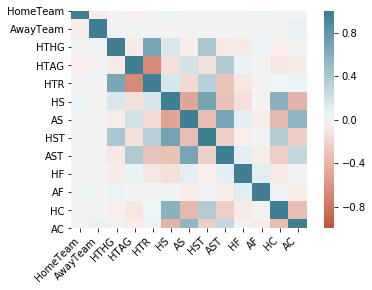

In [34]:
corr = df_train_x.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

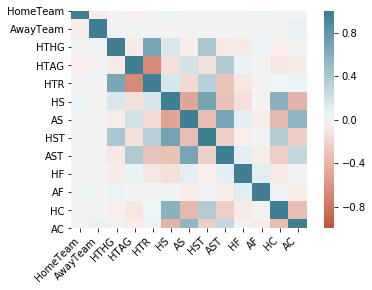

In [35]:
corr = df_train_x.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

   After plotting the correlation matrix, we can see quite clearly
   strong relations between some pair of variables, whose squares are more blue
       - HST and HS (short on target and shot)
       - AST and AS
   Naturally, the team who have more shots is more likely to have more shot on target
       - HS and HC (short and corner)
   Also, the team who shot more will receive more corner kicks.
       - AS and AC
   As well as inverse relation between:
       - AS and HS
       - HS and AC, HC and AS

## 2.2 Pair plot

The correlation of aforementioned variables can be further demonstrated with pair plots below.

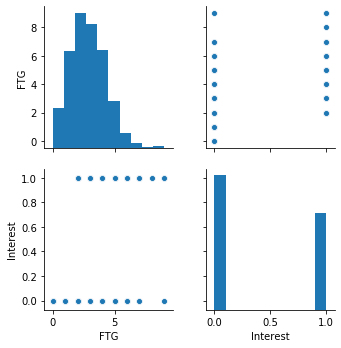

In [31]:
sns.pairplot(df_train_x[["FTG","Interest"]])
plt.show()

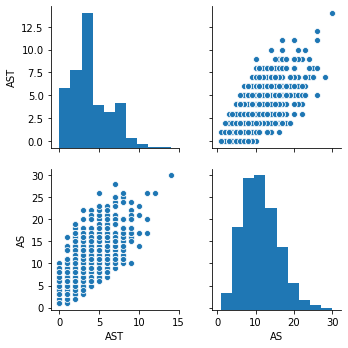

In [37]:
sns.pairplot(df_train_x[["AST","AS"]])
plt.show()

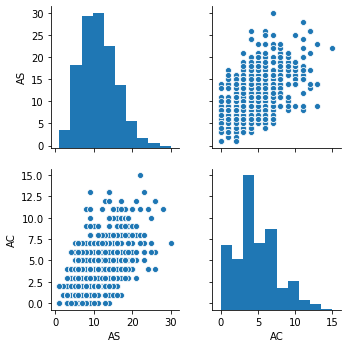

In [38]:
sns.pairplot(df_train_x[["AS","AC"]])
plt.show()

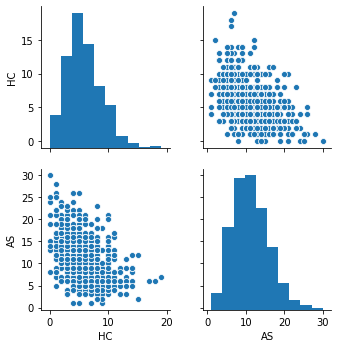

In [39]:
sns.pairplot(df_train_x[["HC","AS"]])
plt.show()

In [40]:
df_train_x.isnull().sum()

HomeTeam    0
AwayTeam    0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
dtype: int64

## 2.3 PCA

PCA is effected by scale so you need to scale the features in your data before applying PCA. Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. If you want to see the negative effect not scaling your data can have, scikit-learn has a section on the effects of not standardizing your data.

In [45]:
df_train_x.columns

Index(['HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST',
       'HF', 'AF', 'HC', 'AC', 'Interest', 'FTG'],
      dtype='object')

In [55]:
features = df_train_x.columns
print(features)
x = df_train_x.loc[:, features].values
x = df_train_x
x = StandardScaler().fit_transform(x)

Index(['HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST',
       'HF', 'AF', 'HC', 'AC', 'Interest', 'FTG'],
      dtype='object')


In [56]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [57]:
principalComponents

array([[ 2.12500183,  2.30720941],
       [ 1.53489125,  0.37330639],
       [-1.07075522,  0.80918606],
       ...,
       [-2.89537184,  1.35484396],
       [ 0.34488929,  0.21632953],
       [ 2.4464022 ,  0.79154466]])

In [58]:
pca.explained_variance_ratio_


array([0.22652036, 0.14921082])

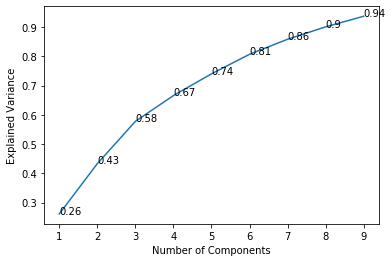

In [62]:
features = df_train_x.columns[2:]
x = df_train_x.loc[:, features].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])
x = np.arange(1,10,1)
y = cum_explained_var
plt.plot(np.arange(1,10,1),cum_explained_var)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
for a,b in zip(x, y): 
    plt.text(a, b, str(round(b,2)))
plt.show()


[ 0.21081436 -0.21875245  0.28448554  0.42509152 -0.4054578   0.39636382
 -0.35662465 -0.09270828  0.03070993  0.31694396 -0.28351934  0.08200104
  0.01701836]


<Figure size 432x288 with 0 Axes>

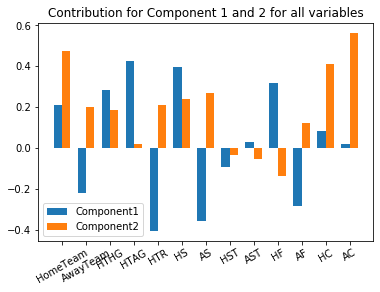

In [61]:
fig = plt.figure()
labels = df_train_x.columns
comp1 = pca.components_[0]
comp2 = pca.components_[1]
print(comp1)
width = 0.35  # the width of the bars
x = np.arange(len(comp1))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, comp1, width, label='Component1')
rects2 = ax.bar(x + width/2, comp2, width, label='Component2')
ax.set_title('Contribution for Component 1 and 2 for all variables')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=30)
ax.legend()
fig.savefig('test.png')


In [63]:
comp1.shape

(13,)

In [65]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()


IndexError: too many indices for array

We can see that 2 components only explain 48.77% of the total variance.

# 3. Regression

The goal of this task is to predict the number of goals of the match based on all or some of the features. You should
complete the following; You can:

• Try to understand and explain which features are the strongest predictor for total number of goals in a match
and why.

• Analyze your data, see if there is a linear trend or not. Try different regression models. If you want, you can
also try a quadratic model. Explain your result(s). If you try different models, remember to compare them and
explain all of them.

• Adopt PCA to reduce the dimension of your data set. Select the right number of components by checking the
variance explained by components. Use the projected train and test set to predict the total number of the goals
for matches in the test set. compare your result obtained after adopting the PCA with without PCA and explain
your results/observation.

In [ ]:
df_train_combined = df_train_x.join(df_train_y)
corr_res = df_train_combined.corr()
ax = sns.heatmap(
    corr_res,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [ ]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = df_train_combined.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


We can see that compared to other features, HST and AST have a stronger effect on FTG overall.

In [ ]:
sns.pairplot(df_train_combined[["AS","AST"]])
plt.show()

As can be seen from the pair plots, HST and AST both have a positive linear relations with FTG.

In [ ]:
reg = LinearRegression().fit(df_train_x, df_train_y["FTG"])
reg.score(df_train_x, df_train_y["FTG"])
y_pred_train = reg.predict(df_train_x)
y_pred = reg.predict(df_test_x)
mean_squared_error(y_pred,df_test_y["FTG"])
print("train r2: "+str(reg.score(df_train_x,df_train_y["FTG"])))
print("train mse: "+str(mean_squared_error(y_pred_train,df_train_y["FTG"])))
print("test r2: "+str(reg.score(df_test_x,df_test_y["FTG"])))
print("test MSE: "+str(mean_squared_error(y_pred,df_test_y["FTG"])))
# reg.score(df_test_x,df_test_y["FTG"])

Coefficient of determination is rather low with the linear regression model, only 25% of total variance can be explained with explained variance.
We continue by removing the linearly related features, as mentioned above.

In [ ]:
df_train_x.columns

In [ ]:
regression_cols = ['HomeTeam', 'AwayTeam', 'HTR', 'HST', 'AST', 'HF', 'AF']
reg2 = LinearRegression().fit(df_train_x[regression_cols], df_train_y["FTG"])
reg2.score(df_train_x[regression_cols], df_train_y["FTG"])
y_pred2 = reg2.predict(df_train_x[regression_cols])
mean_squared_error(y_pred2,df_train_y["FTG"])
reg2.score(df_test_x[regression_cols],df_test_y["FTG"])


this one is worse

In [ ]:
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = numpy.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results


In [ ]:
polyfit(df_train_x,df_train_y["FTG"],2)

In [ ]:
# x_train = df_train_x.loc[:, features].values
# x_test = df_test_x.loc[:, features].values

x_train = df_train_x
x_test = df_test_x
rSquared_train = []
rSquared_test = []
mse_train = []
mse_test = []

for i in range(2,10):
    pca = PCA(n_components=i)
    principalComponents_train = pca.fit_transform(x_train)
    principalComponents_test = pca.fit_transform(x_test)
    reg_temp = LinearRegression().fit(principalComponents_train, df_train_y["FTG"])
    score_temp = reg_temp.score(principalComponents_train, df_train_y["FTG"])
    y_pred_train = reg_temp.predict(principalComponents_train)
    # calculate training accuracy
    mse_train.append(mean_squared_error(y_pred_train,df_train_y["FTG"]))
    rSquared_train.append(score_temp)
    # calculate testing accuracy
    y_pred_test = reg_temp.predict(principalComponents_test)
    score_temp_test = reg_temp.score(principalComponents_test, df_test_y["FTG"])
    mse_test.append(mean_squared_error(y_pred_test,df_test_y["FTG"]))
    rSquared_test.append(score_temp_test)

    


In [ ]:
print(np.array(mse_train).T)
print(rSquared_train)
print(mse_test)
print(rSquared_test)


In [ ]:
print(mse)
print(rSquared)

polynomial


In [49]:
poly = PolynomialFeatures(degree = 4) 
X_poly_train = poly.fit_transform(df_train_x)
X_poly_test = poly.fit_transform(df_test_x)
lin2 = LinearRegression() 
lin2.fit(X_poly_train, df_train_y["FTG"]) 
print(mean_squared_error(lin2.predict(X_poly_train),df_train_y["FTG"]))
print(mean_squared_error(lin2.predict(X_poly_test),df_test_y["FTG"]))



1.4217141434368626e-26
37.08823353283484


In [ ]:
"""
rSquared_train = []
rSquared_test = []
mse_train = []
mse_test = []
for i in range(2,10):
    pca = PCA(n_components=i)
    principalComponents_train = pca.fit_transform(x_train)
    principalComponents_test = pca.fit_transform(x_test)
    X_poly = poly.fit_transform(df_train_x) 
    X_poly_test = poly.fit_transform(df_test_x) 
    poly_reg = LinearRegression() 
    poly_reg.fit(X_poly, df_train_y["FTG"]) 

    score_temp = poly_reg.score(principalComponents_train, df_train_y["FTG"])
    y_pred_train = reg_temp.predict(X_poly)
    # calculate training accuracy
    mse_train.append(mean_squared_error(y_pred_train,df_train_y["FTG"]))
    rSquared_train.append(score_temp)
    # calculate testing accuracy
    y_pred_test = reg_temp.predict(X_poly_test)
    score_temp_test = reg_temp.score(X_poly_test, df_test_y["FTG"])
    mse_test.append(mean_squared_error(y_pred_test,df_test_y["FTG"]))
    rSquared_test.append(score_temp_test)
"""


# 3. Classification

## 3.1. KNN- Classification

### 3.1.1. Determining the number of clusters with the elbow method

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.


In [50]:
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_train_x)
    Sum_of_squared_distances.append(km.inertia_)

As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.
Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.


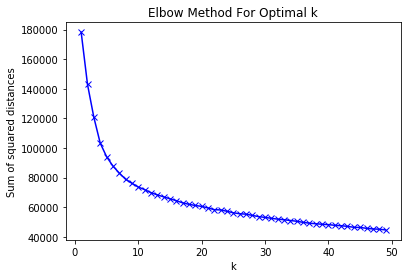

In [53]:
fig = plt.figure()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()
fig.savefig("test.png")

Unfortunately, we do not always have such clearly clustered data. This means that the elbow may not be clear and sharp.
However, in our case, the elbow is quite not apparent; therefore we may use the Silhouette Method.

### 3.1.1. Determining the number of clusters with the Silhouette Method

In [60]:
sil = []
kmax = 19

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(df_train_x)
    labels = kmeans.labels_
    score = silhouette_score(df_train_x, labels, metric = 'euclidean')
    sil.append(score)
    # print("For "+ str(k)+ " clusters, silhouette score is "+ str(score))
    print(score)

0.19180275650453482
0.1869525902797281
0.19173836704385536
0.18483029543680943
0.17000878064398997
0.16279734475323984
0.1557313595210895
0.1470834068726093
0.13631167357417479
0.13548767254870075
0.12997946816834652
0.12340694146388818
0.13315281597532988
0.12519152711467973
0.1260314018407034
0.12028177003120509
0.12142261078228453
0.12166616315683874


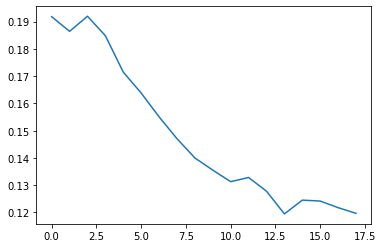

In [58]:
plt.plot(sil,)
plt.show()

There is a clear peak at k = 2. Hence, it is optimal.
Finally, the data can be optimally clustered into 2 clusters as shown below.

### 3.1.2 Classifying data using KMean

In [87]:
x_train = df_train_x.loc[:, features].values
x_test = df_test_x.loc[:, features].values
accuracy_level = []

for j in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=j, metric='euclidean')
    knn.fit(x_train,df_train_y["Interest"])
    y_pred = knn.predict(x_test)
    noPCAAcc = accuracy(confusion_matrix(y_pred,df_test_y.Interest))
    accuracy_level.append(noPCAAcc)
    print("")
    print("Without PCA")
    for i in range(2,5):
        # model without PCA
        pca = PCA(n_components=i)
        principalComponents_train = pca.fit_transform(x_train)
        principalComponents_test = pca.fit_transform(x_test)
        knn.fit(principalComponents_train, df_train_y["Interest"])
        y_pred = knn.predict(principalComponents_test)
        temp_acc = accuracy(confusion_matrix(y_pred,df_test_y.Interest))
        accuracy_level.append(temp_acc)
        print("PCA of "+str(i)+" components" )

max(accuracy_level)


Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components

Without PCA
PCA of 2 components
PCA of 3 components
PCA of 4 components


0.6461988304093568

Given our confusion matrix, we have the accuracy as (169 + 33)/ (169+33+25+115) = 59%

Given our confusion matrix, we have the accuracy with PCA component 2 as (110 + 55)/ (342) = 48%

In [62]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 


## 3.2 Using Logistic Regression to classify

In [88]:
logit_model=sm.Logit(df_train_y["Interest"],df_train_x)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.591144
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.130     
Dependent Variable: Interest         AIC:              969.4654  
Date:               2019-12-01 13:03 BIC:              1030.3328 
No. Observations:   798              Log-Likelihood:   -471.73   
Df Model:           12               LL-Null:          -542.16   
Df Residuals:       785              LLR p-value:      4.0112e-24
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
HomeTeam       0.0205    0.0108   1.9036  0.0570  -0.0006   0.0417
AwayTeam      -0.0047    0.0103  -0.4557  0.6486  -0.0248   0.

We choose variables with p-values smaller than 0.05, except four variables.

In [92]:
cols = ["HTHG","HTAG","HST","HF","AF"]
train_x = df_train_x[cols]
train_y = df_train_y["Interest"]
logit_model=sm.Logit(train_y,train_x)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.601971
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.114     
Dependent Variable: Interest         AIC:              970.7452  
Date:               2019-12-01 13:27 BIC:              994.1558  
No. Observations:   798              Log-Likelihood:   -480.37   
Df Model:           4                LL-Null:          -542.16   
Df Residuals:       793              LLR p-value:      9.1689e-26
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
HTHG       0.7706     0.1100    7.0030   0.0000    0.5549    0.9863
HTAG       0.4692     0.1028    4.5647   0.0000    0.2677 

In [94]:
logreg = LogisticRegression()
logreg.fit(train_x, train_y)
y_pred = logreg.predict(df_test_x[cols])
accuracy(confusion_matrix(y_pred,df_test_y["Interest"]))

c:\users\dylan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6783625730994152

In [96]:
logreg = LogisticRegression()
logreg.fit(df_train_x, train_y)
y_pred = logreg.predict(df_test_x)
accuracy(confusion_matrix(y_pred,df_test_y["Interest"]))

c:\users\dylan\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6695906432748538

In [ ]:
RF_clf = RandomForestClassifier(n_estimators = 135, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)


In [ ]:
RF_clf.fit(df_train_x,df_train_y["Interest"])
y_pred = RF_clf.predict(df_test_x)
accuracy(confusion_matrix(y_pred,df_test_y["Interest"]))


In [ ]:
AB_clf.fit(df_train_x,df_train_y["Interest"])
y_pred = AB_clf.predict(df_test_x)
accuracy(confusion_matrix(y_pred,df_test_y["Interest"]))